# **Proyecto Turismo de los Alpes**

# **1. Entendimiento de los datos**

In [ ]:
!pip install unidecode
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1e1e808e80b3c7d269b1fb94b56ef6ddb203a02a0ad6c6c95f1a1a77268aa789
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
# Cargar librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Cargar datos

df = pd.read_csv("tipo2_entrenamiento_estudiantes.csv")
print(df.head())

                                              Review  Class
0  Muy buena atención y aclaración de dudas por p...      5
1  Buen hotel si están obligados a estar cerca de...      3
2  Es un lugar muy lindo para fotografías, visite...      5
3  Abusados con la factura de alimentos siempre s...      3
4  Tuvimos un par de personas en el grupo que rea...      3


In [ ]:
# Indentificar información general de los datos

print(df.shape)
print(df.dtypes)

(7875, 2)
Review    object
Class      int64
dtype: object


Se compartieron datos de 7875 reseñas de turistas de los cuales tenemos una unica columna object "Review" en el que se encuentra toda la información de la reseña escrita. Por otro lado, hay una unica columna númerica "Class" que guarda el nivel de satisfación del turista con base en la reseña.

In [ ]:
# Analizar distribución de la variable numerica

df.describe()

,Class
count,7875.000000
mean,3.502603
std,1.320435
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Se identifica que class esta dentro de su rango adecuado, con 5 de valor maximo y 1 de valor minimo. Tocaria evaluar si esta es entera en todos los valores.

In [ ]:
# Analizar la completitud de los datos

print(df.isna().sum())

Review    0
Class     0
dtype: int64


Se observa que no hay ningún dato nulo en el conjunto de reseñas compartido

In [ ]:
# Analizar la unicidad de los datos

df.duplicated().sum()

73

Se observa que hay 73 reseñas duplicadas, es decir, 0.0093% de los datos se encuentran duplicados, por ende, se debe tratar estos datos.

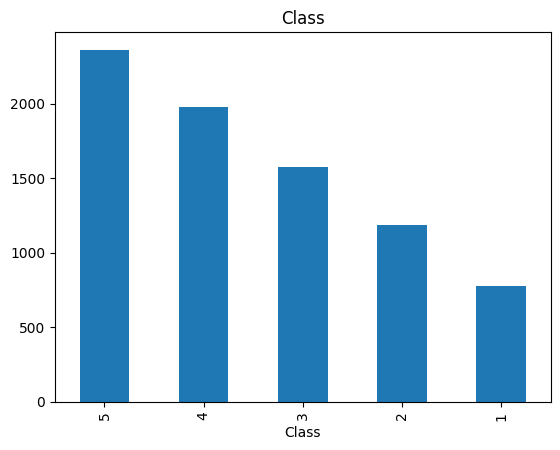

In [ ]:
# Analizar validez de la variable númerica

df["Class"].value_counts().plot(kind="bar")
plt.title("Class")
plt.show()

Para la columna "Class" se observa un correcta validez al tener datos unicamente en las 5 clases que hay númeradas del 1 al 5.

#**2. Preparación de los datos**

La preparación de los datos se va a dividir en tres etapas:

*   Limpieza de los datos.
*   Tokenización.
*   Normalización (Vectorización).



En esta parte lo que se hace es eliminar todo tipo de caracteres especiales y tener todas las palabras en minúscula

Primero se instalan todas las librerías y dependencias necesarias

In [ ]:
# Eliminación de datos duplicados

#df = df.drop_duplicates(subset=["Review"]) Error de ejecución que no se pudo debuggear

In [ ]:
"""
Función para limpiar el texto.
Eliminar signos de puntuación, caracteres especiales, tildes y
convertir todo a minúsculas
"""
def limpiar_texto(texto):
    texto_limpio = re.sub(r'[^\w\s]', '', texto)
    texto_limpio = unidecode(texto_limpio.lower())
    return texto_limpio

df["Review"] = df["Review"].apply(limpiar_texto)
print(df.head())

                                              Review  Class
0  muy buena atencion y aclaracion de dudas por p...      5
1  buen hotel si estan obligados a estar cerca de...      3
2  es un lugar muy lindo para fotografias visiten...      5
3  abusados con la factura de alimentos siempre s...      3
4  tuvimos un par de personas en el grupo que rea...      3


In [ ]:
"""
Función para eliminar palabras vacías de una reseña,
Separa la cadena en palabras, elimina las palabras vacías, y vuelve a unir
"""
def eliminar_stopwords(texto):
    stop_words = set(stopwords.words("spanish"))
    palabras_filtradas = [palabra for palabra in texto.split() if palabra not in stop_words]
    texto_filtrado = ' '.join(palabras_filtradas)
    return texto_filtrado

df["Review"] = df["Review"].apply(eliminar_stopwords)
print(df.head())

                                              Review  Class
0  buena atencion aclaracion dudas parte senorita...      5
1  buen hotel si estan obligados cerca centro con...      3
2  lugar lindo fotografias visiten selina musica ...      5
3  abusados factura alimentos siempre echan culpa...      3
4  par personas grupo realmente queriamos comer c...      3


In [ ]:
"""
Función para lematizar las palabras de una reseña,
Separa la cadena en palabras, lematiza las palabras, y vuelve a unir
"""
def lematizar_texto(texto):
    lemmatizer = WordNetLemmatizer()
    palabras_lematizadas = [lemmatizer.lemmatize(palabra) for palabra in texto.split()]
    texto_lematizado = ' '.join(palabras_lematizadas)
    return texto_lematizado

df["Review"] = df["Review"].apply(lematizar_texto)
print(df.head())

                                              Review  Class
0  buena atencion aclaracion dudas parte senorita...      5
1  buen hotel si estan obligados cerca centro con...      3
2  lugar lindo fotografias visiten selina musica ...      5
3  abusados factura alimentos siempre echan culpa...      3
4  par persona grupo realmente queriamos comer ca...      3


In [ ]:
"""
Función para convertir números en su representación textual en español en una reseña
"""
def convertir_numeros_texto(texto):
    texto_con_numeros_convertidos = re.sub(r'\b\d+\b', lambda x: num2words(int(x.group()), lang='es'), texto)
    return texto_con_numeros_convertidos

df["Review"] = df["Review"].apply(convertir_numeros_texto)
print(df.head())

                                              Review  Class
0  buena atencion aclaracion dudas parte senorita...      5
1  buen hotel si estan obligados cerca centro con...      3
2  lugar lindo fotografias visiten selina musica ...      5
3  abusados factura alimentos siempre echan culpa...      3
4  par persona grupo realmente queriamos comer ca...      3


In [ ]:
"""
Función para vectorizar las palabras de las review
"""
tfidf_vectorizer = TfidfVectorizer()

def crear_matriz_TFIDF(df):
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df_tfidf['Variable_Objetivo'] = df['Class']
    return df_tfidf

df_tfidf = crear_matriz_TFIDF(df)
print(df_tfidf.shape)
df_tfidf.head()

(7875, 26013)


,0600am,0900hrs,0llegamos,0me,1000am,1000p,100h,100pesos,100vale,100x100,...,zoom,zu,zuizas,zumba,zumbaba,zumo,zumos,zur,zuzzete,Variable_Objetivo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
X_data = df_tfidf.drop(columns=["Variable_Objetivo"])
Y_data = df_tfidf["Variable_Objetivo"]

#**3. Creación del modelo**

### **Modelo para el algoritmo de Regresión Logistica Multinomial (Jefferson Hernandez - 202120242)**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


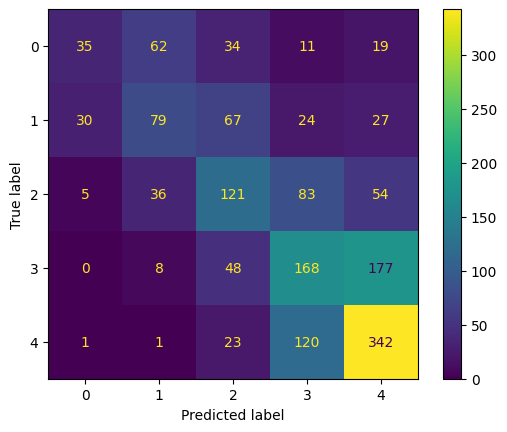

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión logística multinomial
modelo_reg_log_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Entrenar el modelo con los datos de entrenamiento
modelo_reg_log_multinomial.fit(X_train, Y_train)

# Predecir las clases en el conjunto de prueba
predicciones = modelo_reg_log_multinomial.predict(X_test)

# Visualiza la matriz de confusión
cm = confusion_matrix(Y_test, predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Mostrar el reporte de clasificación

print(classification_report(Y_test, predicciones))

              precision    recall  f1-score   support

           1       0.49      0.22      0.30       161
           2       0.42      0.35      0.38       227
           3       0.41      0.40      0.41       299
           4       0.41      0.42      0.42       401
           5       0.55      0.70      0.62       487

    accuracy                           0.47      1575
   macro avg       0.46      0.42      0.43      1575
weighted avg       0.47      0.47      0.46      1575



### **Modelo para el algoritmo de arboles de decisión (Samuel Goncalves - 202122595)**

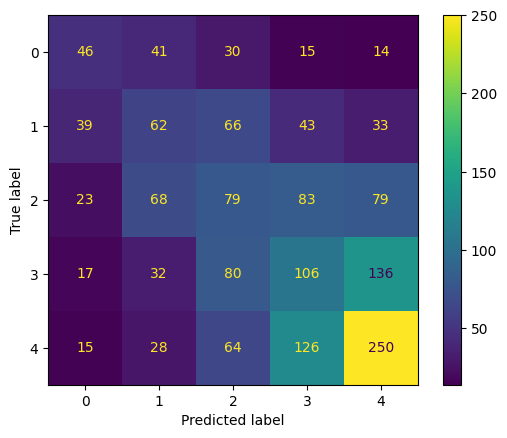

In [ ]:
# Dividir datos en entrenamiento (80%) y test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size = 0.8, random_state=1234, shuffle=True)

# Crear el objeto de arbol de decisión utilizando como criterio de pureza la entropía
arbol = DecisionTreeClassifier(criterion="entropy", random_state=0)

# Entrenar el modelo con los datos de entrenamiento
arbol = arbol.fit(X_train, Y_train)

# Determinar las predicciones del modelo sobre el conjunto de prueba
Y_pred = arbol.predict(X_test)

# Generar matriz de confusión
confusion_matrix(Y_test, Y_pred)

Y_pred = arbol.predict(X_test)

# Calcula la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Visualiza la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Mostrar reporte de clasificación

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.33      0.32      0.32       146
           2       0.27      0.26      0.26       243
           3       0.25      0.24      0.24       332
           4       0.28      0.29      0.28       371
           5       0.49      0.52      0.50       483

    accuracy                           0.34      1575
   macro avg       0.32      0.32      0.32      1575
weighted avg       0.34      0.34      0.34      1575



### **Modelo para el algoritmo de Maquinas de Vector de Soporte [SVM] (Ronald Pardo Diaz - 202111309)**

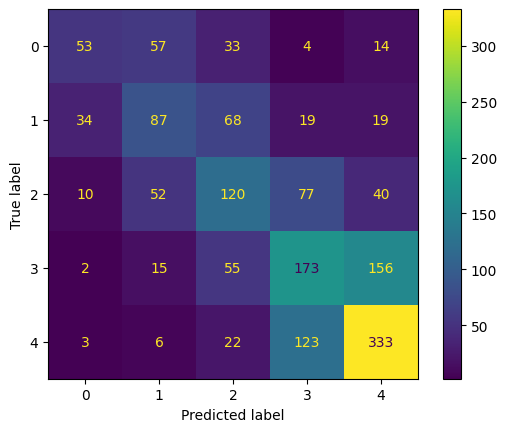

In [ ]:
# Dividir datos en entrenamiento y prueba

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Creación y entrenamiento del modelo SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, Y_train)

# Evaluación del modelo
Y_pred = svm_model.predict(X_test)

# Calcula la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Visualiza la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Mostrar reporte de clasificación

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.52      0.33      0.40       161
           2       0.40      0.38      0.39       227
           3       0.40      0.40      0.40       299
           4       0.44      0.43      0.43       401
           5       0.59      0.68      0.63       487

    accuracy                           0.49      1575
   macro avg       0.47      0.45      0.45      1575
weighted avg       0.48      0.49      0.48      1575



# **4. Clasificación nuevos datos**

In [ ]:
# Convierte la matriz dispersa a una matriz densa antes de usar argsort()
sorted_coef_index = svm_model.coef_[0].argsort()

feature_names = np.array(X_data.columns)

# Obtener las 10 características más negativas y más positivas
print('Las 30 características más positivas: \n{}\n'.format(feature_names[sorted_coef_index[:30]]))
print('Las 30 características más negativas: \n{}'.format(feature_names[sorted_coef_index[:-31:-1]]))

Las 30 características más positivas: 
['bien' 'gente' 'subir' 'gran' 'bueno' 'buena' 'historia' 'agradable'
 'viejo' 'desayuno' 'precio' 'siquiera' 'mojitos' 'vendedores' 'dentro'
 'demasiado' 'control' 'salon' 'mojito' 'ser' 'habitacion' 'piso' 'caro'
 'dos' 'guia' 'bastante' 'visita' 'interesante' 'igual' 'parecio']

Las 30 características más negativas: 
['peor' 'horrible' 'asco' 'pesima' 'cover' 'pesimo' 'ayer' 'recorrido'
 'chico' 'jamas' 'robo' 'rota' 'nunca' 'cubano' 'nardo' 'persona' 'sucias'
 'vuelta' 'tardo' 'noma' 'llegada' 'sabado' 'respuesta' 'cero' 'sucia'
 'asqueroso' 'quemas' 'lamentable' 'terminar' 'seguridad']


In [ ]:
# Cargar datos nuevos
datos_nuevos_original = pd.read_csv("particion_prueba_estudiantes.csv")
datos_nuevos = datos_nuevos_original.copy()

# Preprocesamiento de las nuevas reseñas
datos_nuevos["Review"] = datos_nuevos["Review"].apply(limpiar_texto)
datos_nuevos["Review"] = datos_nuevos["Review"].apply(eliminar_stopwords)
datos_nuevos["Review"] = datos_nuevos["Review"].apply(lematizar_texto)
datos_nuevos["Review"] = datos_nuevos["Review"].apply(convertir_numeros_texto)

# Vectorización  de los nuevos datos usando el mismo vectorizador TF-IDF
X_new_tfidf = tfidf_vectorizer.transform(datos_nuevos["Review"])

# Predicción con el modelo entrenado
predictions = modelo_reg_log_multinomial.predict(X_new_tfidf)

# Crear un nuevo DataFrame con las predicciones
predicciones_df = pd.DataFrame({"Review": datos_nuevos_original["Review"], "Class": predictions})

# Guardar el DataFrame en un archivo CSV
predicciones_df.to_csv("predicciones.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
